In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import neo
import elephant 
import viziphant

## Generate a gamma process

In [2]:
# Regularity defined by `shape_factor`: higher values -> more clock-like
rate = 20*pq.Hz
gamma_shape_factor = 20
duration = 60*pq.s

gamma_process = elephant.spike_train_generation.StationaryGammaProcess(
    rate=rate, 
    shape_factor=gamma_shape_factor,
    t_start=0*pq.ms,
    t_stop=duration)

st = gamma_process.generate_spiketrain()

In [3]:
# Show resulting SpikeTrain
st

SpikeTrain containing 1193 spikes; units s; datatype float64 
time: 0.0 s to 60.0 s

## Plot the first seconds of the spike train

<Axes: xlabel='Time (s)'>

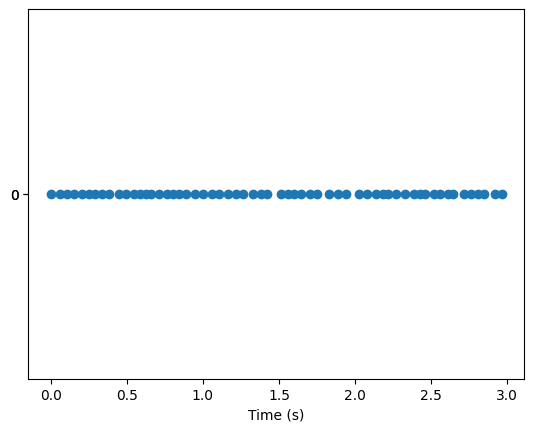

In [4]:
# Slice spike train to first few seconds before plotting
viziphant.rasterplot.rasterplot(
    [st.time_slice(t_start=0*pq.ms, t_stop=3000*pq.ms)])

## Create a binned representation of the spike train

In [5]:
bin_size = 1*pq.ms
bst = elephant.conversion.BinnedSpikeTrain(
    st, bin_size=bin_size)

In [6]:
# Show dimensions of the spike train
assert(bst.to_array().shape[1] == (duration/bin_size).simplified.magnitude)
bst.to_array().shape

(1, 60000)

## Convert binned spike train object to a time series object

In [7]:
binned_spikes_timeseries = neo.AnalogSignal(
    bst.to_array().transpose()/bst.bin_size.magnitude*pq.dimensionless, 
    t_start=bst.t_start, 
    sampling_period=bst.bin_size)

## Create a Welch PSD estimate

In [8]:
# Convert binned spike train to an Analog Signal in order to retain the units
n_segments = 10
overlap = 0
f_w,psd_w = elephant.spectral.welch_psd(
    binned_spikes_timeseries, n_segments=n_segments, overlap=overlap)

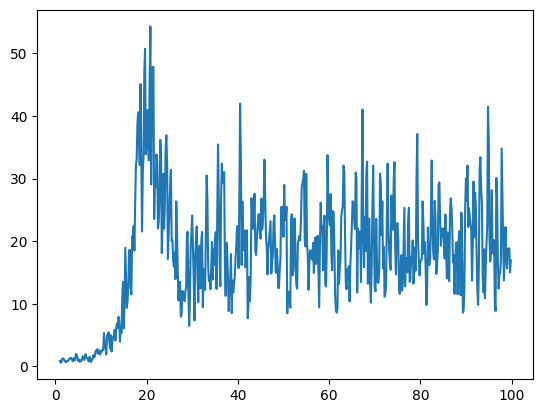

In [9]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.searchsorted(f_w.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_w.rescale(pq.Hz).magnitude, 100)
plt.plot(f_w[lower_f_index:upper_f_index], np.transpose(psd_w[0, lower_f_index:upper_f_index]/2))

In [10]:
# Check average power in tail
lower_f_index = np.where(f_w>50)[0][0]
upper_f_index = np.where(f_w>100)[0][0]
np.mean(np.transpose(psd_w[0,lower_f_index:upper_f_index])/2)

array(19.92440545) * 1/Hz

## Create a multitaper PSD estimate

In [11]:
# Convert binned spike train to an Analog Signal in order to retain the units
f_mt, psd_mt = elephant.spectral.multitaper_psd(
    binned_spikes_timeseries)

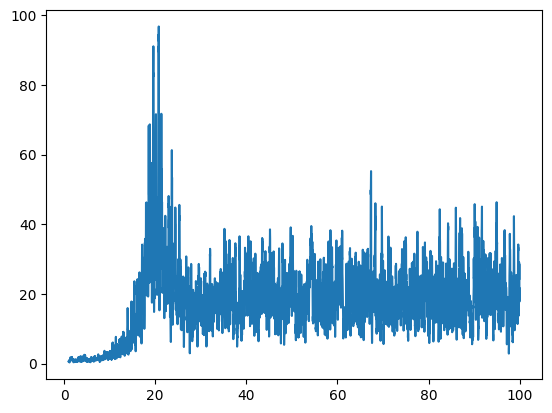

In [12]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.searchsorted(f_mt.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_mt.rescale(pq.Hz).magnitude, 100)
plt.plot(f_mt[lower_f_index:upper_f_index], np.transpose(psd_mt[0, lower_f_index:upper_f_index]/2))

In [13]:
# Check average power in tail
lower_f_index = np.where(f_mt>50)[0][0]
upper_f_index = np.where(f_mt>100)[0][0]
np.mean(np.transpose(psd_mt[0,lower_f_index:upper_f_index])/2)

array(19.93921759) * 1/Hz

## Create a multi-segment averaged multitaper PSD estimate

In [14]:
# Convert binned spike train to an Analog Signal in order to retain the units
f_mtn, psd_mtn = elephant.spectral.segmented_multitaper_psd(
    binned_spikes_timeseries, n_segments=n_segments, overlap=overlap)

/home/denker/miniconda3/envs/elephant_0.14.0/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


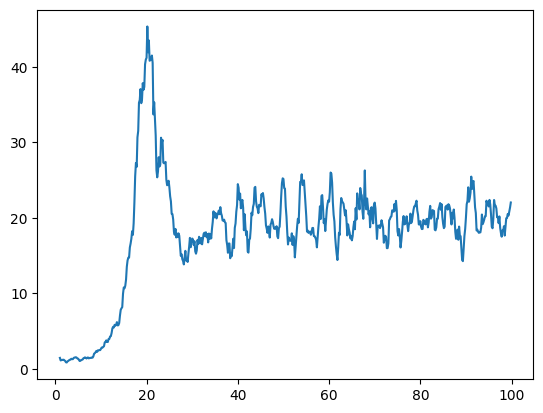

In [15]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.searchsorted(f_mtn.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_mtn.rescale(pq.Hz).magnitude, 100)
plt.plot(f_mtn[lower_f_index:upper_f_index], np.transpose(psd_mtn[0, 0, lower_f_index:upper_f_index]/2))

## Bos spectra

In [16]:
# This is the power spectrum code found for Bos et al., 2018, https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005132
def powerspec(data, tbin, Df=None, units=False, N=None):
    '''
    Calculate (smoothed) power spectra of all timeseries in data. 
    If units=True, power spectra are averaged across units.
    Note that averaging is done on power spectra rather than data.

    Power spectra are normalized by the length T of the time series -> no scaling with T. 
    For a Poisson process this yields:

    **Args**:
       data: numpy.ndarray; 1st axis unit, 2nd axis time
       tbin: float; binsize in ms
       Df: float/None; window width of sliding rectangular filter (smoothing), None -> no smoothing
       units: bool; average power spectrum 

    **Return**:
       (freq, POW): tuple
       freq: numpy.ndarray; frequencies
       POW: if units=False: 2 dim numpy.ndarray; 1st axis unit, 2nd axis frequency
            if units=True:  1 dim numpy.ndarray; frequency series

    **Examples**:
       >>> powerspec(np.array([analog_sig1,analog_sig2]),tbin, Df=Df)
       Out[1]: (freq,POW)
       >>> POW.shape
       Out[2]: (2,len(analog_sig1))

       >>> powerspec(np.array([analog_sig1,analog_sig2]),tbin, Df=Df, units=True)
       Out[1]: (freq,POW)
       >>> POW.shape
       Out[2]: (len(analog_sig1),)

    '''
    if N is None:
        N = len(data)
    freq, DATA = calculate_fft(data, tbin)
    df = freq[1] - freq[0]
    T = tbin * len(freq)
    POW = np.power(np.abs(DATA),2)
    if Df is not None:
        POW = [movav(x, Df, df) for x in POW]
        cut = int(Df / df)
        freq = freq[cut:]
        POW = np.array([x[cut:] for x in POW])
        POW = np.abs(POW)
    assert(len(freq) == len(POW[0]))
    if units is True:
        POW = 1./N*np.sum(POW, axis=0)
        assert(len(freq) == len(POW))
    POW *= 1. / T * 1e3  # normalization, power independent of T
    return freq, POW


def calculate_fft(data, tbin):
    '''
    calculate the fouriertransform of data
    [tbin] = ms
    '''
    if len(np.shape(data)) > 1:
        n = len(data[0])
        return np.fft.fftfreq(n, tbin * 1e-3), np.fft.fft(data, axis=1)
    else:
        n = len(data)
        return np.fft.fftfreq(n, tbin * 1e-3), np.fft.fft(data)

def movav(y, Dx, dx):
    '''
    calculate average of signal y by using sliding rectangular
    window of size Dx using binsize dx
    '''
    if Dx <= dx:
        return y
    else:
        ly = len(y)
        r = np.zeros(ly)
        n = int(np.round((Dx / dx)))
        r[0:int(n / 2.)] = 1.0 / n
        r[-int(n / 2.)::] = 1.0 / n
        R = np.fft.fft(r)
        Y = np.fft.fft(y)
        yf = np.fft.ifft(Y * R)
        return yf

In [17]:
f_bo, psd_bo = powerspec(
    bst.to_array(), tbin=bin_size.rescale(pq.ms).magnitude, Df=None)

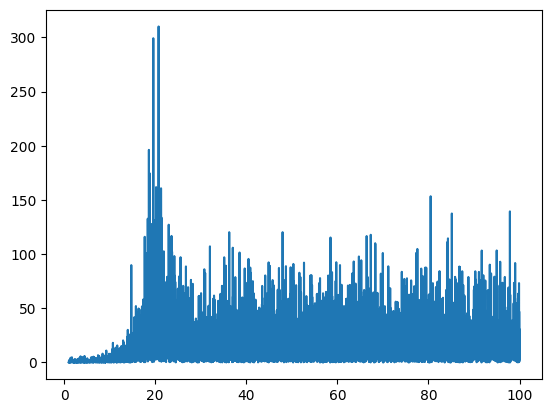

In [18]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.where(f_bo>1)[0][0]
upper_f_index = np.where(f_bo>100)[0][0]
plt.plot(
    f_bo[lower_f_index:upper_f_index], 
    np.transpose(psd_bo[0, lower_f_index:upper_f_index]))

In [19]:
# Check average power in tail
lower_f_index = np.where(f_bo>50)[0][0]
upper_f_index = np.where(f_bo>100)[0][0]
np.mean(np.transpose(psd_bo[0,lower_f_index:upper_f_index]))

19.94111645084843

## Create Bos-like PSD using Elephant

In [20]:
# Convert binned spike train to an Analog Signal in order to retain the units
f_wbc,psd_wbc = elephant.spectral.welch_psd(
    binned_spikes_timeseries, 
    n_segments=1, 
    window='box')

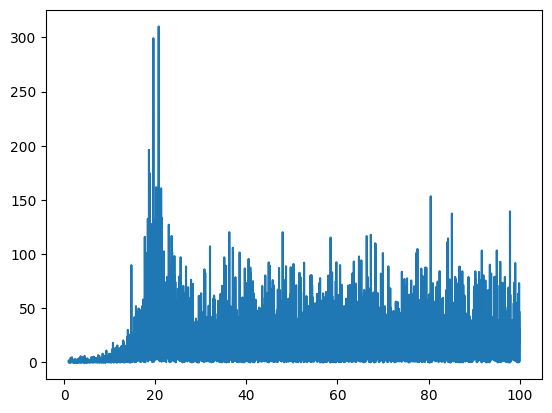

In [21]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.searchsorted(f_wbc.rescale(pq.Hz).magnitude, 1)
upper_f_index = np.searchsorted(f_wbc.rescale(pq.Hz).magnitude, 100)
plt.plot(f_wbc[lower_f_index:upper_f_index], np.transpose(psd_wbc[0, lower_f_index:upper_f_index]/2))

In [22]:
# Check average power in tail
lower_f_index = np.where(f_wbc>50)[0][0]
upper_f_index = np.where(f_wbc>100)[0][0]
np.mean(np.transpose(psd_wbc[0,lower_f_index:upper_f_index])/2)

array(19.94111645) * 1/Hz

## PSD manually without binning

In [23]:
# This code performing a Fourier transform of delta pulses without binning was supplied by HEP. `fs` is a vector of frequencies for which the
# Fourier integral is evaluated as a sum over the deltas. 
def transform(fs, T, spike_times):
    """Calculate PSD of spike train for given frequencies"""
    s = np.asarray([(sum(np.exp(-1j * 2 * np.pi * f * spike_times/1000. )))
                    * (1. if f==0. else 2.) / (T / 1000.) for f in fs])
    return s

In [24]:
#f_zf = f_w.rescale(pq.Hz).magnitude 
f_zf = np.linspace(0, 500, num=5000)
psd_zf = transform(
    f_zf, 
    duration.rescale(pq.ms).magnitude, 
    st.rescale(pq.ms).magnitude)
psd_zf = np.abs(psd_zf*np.conjugate(psd_zf))

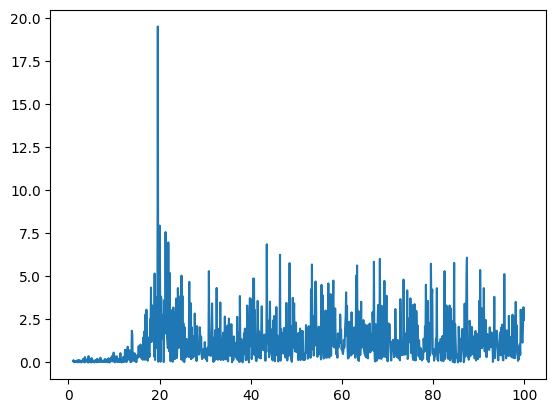

In [25]:
# Limit frequency axis to 1-100 Hz
lower_f_index = np.where(f_zf>1)[0][0]
upper_f_index = np.where(f_zf>100)[0][0]
plt.plot(
    f_zf[lower_f_index:upper_f_index],
    np.transpose(psd_zf[lower_f_index:upper_f_index]))

In [26]:
# Check average power in tail
lower_f_index = np.where(f_zf>50)[0][0]
upper_f_index = np.where(f_zf>100)[0][0]
np.mean(np.transpose(psd_zf[lower_f_index:upper_f_index]))

1.388038211084524

## Theoretical spectrum

In [27]:
# This code is supplied by Tom Tetzlaff to compute the theoretical spectrum of a gamma process

def psd_gamma_process_theoretical(freqs,rate,order):
    '''
    Theoretical power spectrum of a homogeneous Gamma process with integer order gamma
    (see, e.g., eqs.(3.11) and (3.12) in [1]).
    
    [1] Tetzlaff et al. (2008). Dependence of neuronal correlations on filter characteristics 
        and marginal spike train statistics. Neural Computation, 20(9), 2133-2184.

    Parameters:
    -----------

    freqs:        ndarray(float)
                  Array of frequencies (Hz)

    rate:         float
                  Rate of the Gamma process (1/s)

    order:        int
                  Order of the Gamma process

    Returns:
    --------
    P:            ndarray(float)
                  Power spectrum (1/s)/

    '''

    ## characteristic function (Fourier transform) of interval density
    P1 = (order * rate / (order*rate + 2.j*np.pi*freqs))**order

    ## power spectrum (of a renewal process)
    P = rate * np.real(( (1-P1)**(-1) + (1-np.conjugate(P1))**(-1) - 1.0 ))

    return P

f_th = np.array(range(1,200,1))
psd_th = psd_gamma_process_theoretical(f_th,rate.rescale('Hz').magnitude,gamma_shape_factor)

## Summary

Text(0.5, 0, 'f/Hz')

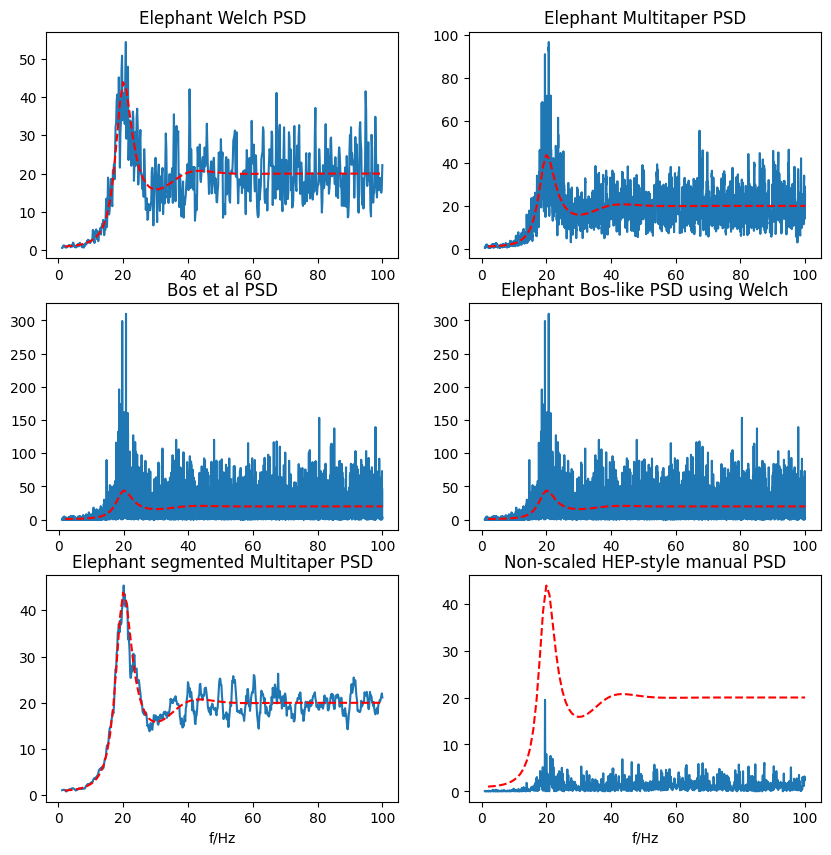

In [28]:
# f axis range to plot
min_f = 1
max_f = 100

# lmits for theoretical spectrum
lower_f_th_index = np.where(f_th>min_f)[0][0]
upper_f_th_index = np.where(f_th>max_f)[0][0]

fig, ax = plt.subplots(3,2,figsize=(10,10))
plt.sca(ax[0,0])
lower_f_index = np.where(f_w.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_w.rescale(pq.Hz).magnitude>max_f)[0][0]
plt.plot(f_w[lower_f_index:upper_f_index], np.transpose(psd_w[0, lower_f_index:upper_f_index]/2))
plt.plot(f_th[lower_f_th_index:upper_f_th_index],psd_th[lower_f_th_index:upper_f_th_index],'r--')
plt.title("Elephant Welch PSD")

plt.sca(ax[0,1])
lower_f_index = np.where(f_mt.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_mt.rescale(pq.Hz).magnitude>max_f)[0][0]
plt.plot(f_mt[lower_f_index:upper_f_index], np.transpose(psd_mt[0, lower_f_index:upper_f_index]/2))
plt.plot(f_th[lower_f_th_index:upper_f_th_index],psd_th[lower_f_th_index:upper_f_th_index],'r--')
plt.title("Elephant Multitaper PSD")

plt.sca(ax[1,0])
lower_f_index = np.where(f_bo>1)[0][0]
upper_f_index = np.where(f_bo>100)[0][0]
plt.plot(f_bo[lower_f_index:upper_f_index],np.transpose(psd_bo[0, lower_f_index:upper_f_index]))
plt.plot(f_th[lower_f_th_index:upper_f_th_index],psd_th[lower_f_th_index:upper_f_th_index],'r--')
plt.title("Bos et al PSD")

plt.sca(ax[1,1])
lower_f_index = np.where(f_wbc.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_wbc.rescale(pq.Hz).magnitude>max_f)[0][0]
plt.plot(f_wbc[lower_f_index:upper_f_index], np.transpose(psd_wbc[0, lower_f_index:upper_f_index]/2))
plt.plot(f_th[lower_f_th_index:upper_f_th_index],psd_th[lower_f_th_index:upper_f_th_index],'r--')
plt.title("Elephant Bos-like PSD using Welch")

plt.sca(ax[2,0])
lower_f_index = np.where(f_mtn.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_mtn.rescale(pq.Hz).magnitude>max_f)[0][0]
plt.plot(f_mtn[lower_f_index:upper_f_index], np.transpose(psd_mtn[0, 0, lower_f_index:upper_f_index]/2))
plt.plot(f_th[lower_f_th_index:upper_f_th_index],psd_th[lower_f_th_index:upper_f_th_index],'r--')
plt.title("Elephant segmented Multitaper PSD")
plt.xlabel("f/Hz")

plt.sca(ax[2,1])
lower_f_index = np.where(f_zf>1)[0][0]
upper_f_index = np.where(f_zf>100)[0][0]
plt.plot(f_zf[lower_f_index:upper_f_index],np.transpose(psd_zf[lower_f_index:upper_f_index]))
plt.plot(f_th[lower_f_th_index:upper_f_th_index],psd_th[lower_f_th_index:upper_f_th_index],'r--')
plt.title("Non-scaled HEP-style manual PSD")
plt.xlabel("f/Hz")

# Peak width comparison of smoothed PSDs

/home/denker/miniconda3/envs/elephant_0.14.0/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


Text(0.5, 1.0, 'Comparison of the peak normalized to max, smoothed by $s$ bins')

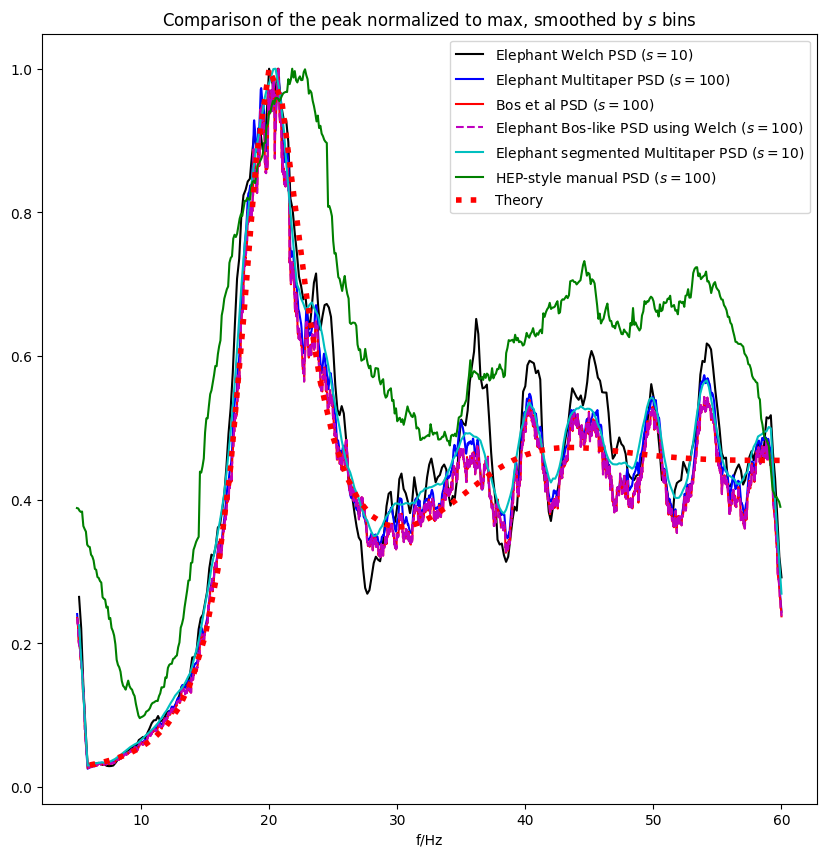

In [29]:
fig = plt.figure(figsize=(10,10))
smooth = 100
min_f = 5
max_f = 60
label = []

lower_f_index = np.where(f_w.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_w.rescale(pq.Hz).magnitude>max_f)[0][0]
x=movav(psd_w[0, lower_f_index:upper_f_index]/2,smooth//n_segments,1)
xm=np.max(x)
plt.plot(f_w[lower_f_index:upper_f_index], np.transpose(x/xm), "k-")
label.append(f"Elephant Welch PSD ($s={(smooth/n_segments):n}$)")

lower_f_index = np.where(f_mt.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_mt.rescale(pq.Hz).magnitude>max_f)[0][0]
x=movav(psd_mt[0, lower_f_index:upper_f_index]/2,smooth,1)
xm=np.max(x)
plt.plot(f_mt[lower_f_index:upper_f_index], np.transpose(x/xm), "b-")
label.append(f"Elephant Multitaper PSD ($s={smooth}$)")

lower_f_index = np.where(f_bo>min_f)[0][0]
upper_f_index = np.where(f_bo>max_f)[0][0]
x=movav(psd_bo[0, lower_f_index:upper_f_index],smooth,1)
xm=np.max(x)
plt.plot(f_bo[lower_f_index:upper_f_index], np.transpose(x/xm), "r-")
label.append(f"Bos et al PSD ($s={smooth}$)")

lower_f_index = np.where(f_wbc.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_wbc.rescale(pq.Hz).magnitude>max_f)[0][0]
x=movav(psd_wbc[0, lower_f_index:upper_f_index]/2,smooth,1)
xm=np.max(x)
plt.plot(f_wbc[lower_f_index:upper_f_index], np.transpose(x/xm), "m--")
label.append(f"Elephant Bos-like PSD using Welch ($s={smooth}$)")

lower_f_index = np.where(f_mtn.rescale(pq.Hz).magnitude>min_f)[0][0]
upper_f_index = np.where(f_mtn.rescale(pq.Hz).magnitude>max_f)[0][0]
x=movav(psd_mtn[0, 0, lower_f_index:upper_f_index]/2,smooth/n_segments,1)
xm=np.max(x)
plt.plot(f_mtn[lower_f_index:upper_f_index], np.transpose(x/xm), "c-")
label.append(f"Elephant segmented Multitaper PSD ($s={(smooth/n_segments):n}$)")

lower_f_index = np.where(f_zf>min_f)[0][0]
upper_f_index = np.where(f_zf>max_f)[0][0]
x=movav(psd_zf[lower_f_index:upper_f_index],smooth,1)
xm=np.max(x)
plt.plot(f_zf[lower_f_index:upper_f_index], np.transpose(x/xm), "g-")
label.append(f"HEP-style manual PSD ($s={smooth}$)")

lower_f_index = np.where(f_th>min_f)[0][0]
upper_f_index = np.where(f_th>max_f)[0][0]
x=psd_th[lower_f_index:upper_f_index] #movav(psd_th[lower_f_index:upper_f_index],smooth,1)
xm=np.max(x)
plt.plot(f_th[lower_f_index:upper_f_index], np.transpose(x/xm), "r:", linewidth=4)
label.append("Theory")

plt.xlabel("f/Hz")
plt.legend(label)
plt.title(f"Comparison of the peak normalized to max, smoothed by $s$ bins")